### Laboratorium 5 - zadania - transformacja Hougha

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### Zadanie 1

Zbadaj wpływ parametrów transformacji Hougha na jakość detekcji prostych na przykładzie obrazu `norway`. Wykorzystaj ulubiony detektor krawędzi i zaprezentuj jego wynik przed użyciem transformacji Hougha. Zapoznaj się z dokumentacją funkcji [`cv2.HoughLines`](https://docs.opencv.org/4.5.3/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a), zwłaszcza parametrami sterującymi rozdzielczością `rho`, `theta` oraz progiem (`threshold`). Błędnie dobrany próg może szczególnie negatywnie wpłynąć na wyniki.

Zacznij od znalezienia odpowiednich parametrów detektora krawędzi - jeśli na tym etapie wyniki będą słabe, to dalej będzie tylko gorzej (_garbage-in, garbage-out_) - ale nie skupiaj się na badaniu ich wpływu na wyniki.

Zadanie _nie_ polega na zrobieniu grid searcha parametrów transformacji Hougha, tylko na zrozumieniu zachowania parametrów `rho` i `theta`, oraz wpływu progu.

Ostateczny rezultat zaprezentuj w postaci odcinków naniesionych na kopię obrazu wejściowego (patrz komórka `[3]`).

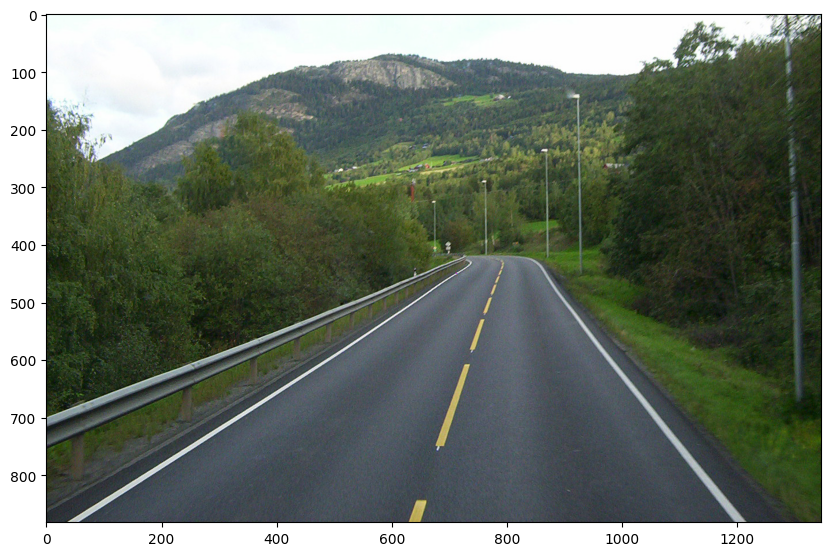

In [14]:
norway = cv2.imread("norway.jpg")
plt.subplots(1, 1, figsize=(10, 10))[1].imshow(norway[..., ::-1])

In [4]:
def rhotheta2xy(line):
    # konwersja parametrów prostej w układzie rho-theta do odcinka w układzie kartezjańskim
    # wynik można użyć jako argumenty funkcji cv2.line
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 5000 * (-b))
    y1 = int(y0 + 5000 * (a))
    x2 = int(x0 - 5000 * (-b))
    y2 = int(y0 - 5000 * (a))
    return x1, y1, x2, y2

Rozwiązanie:

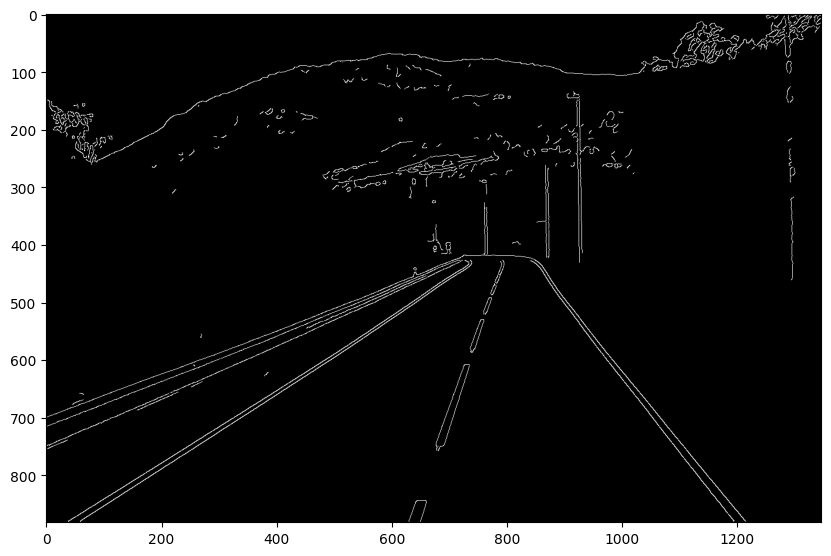

In [15]:
# detect edges
blurred = cv2.GaussianBlur(norway, (9, 9), 0)
edges = cv2.Canny(blurred, 80, 120)

# draw edges
plt.subplots(1, 1, figsize=(10, 10))[1].imshow(edges, cmap="gray")

- In Hugh transform we use Polar coordinates to represent lines:

$$
y = -\frac{\cos\theta}{\sin\theta}x + \frac{r}{\sin\theta}
$$

- `theta`: The resolution of the parameter θ in radians. 
- `threshold`: The minimum number of intersections to "*detect*" a line
- `rho`: The resolution of the parameter r in pixels.   

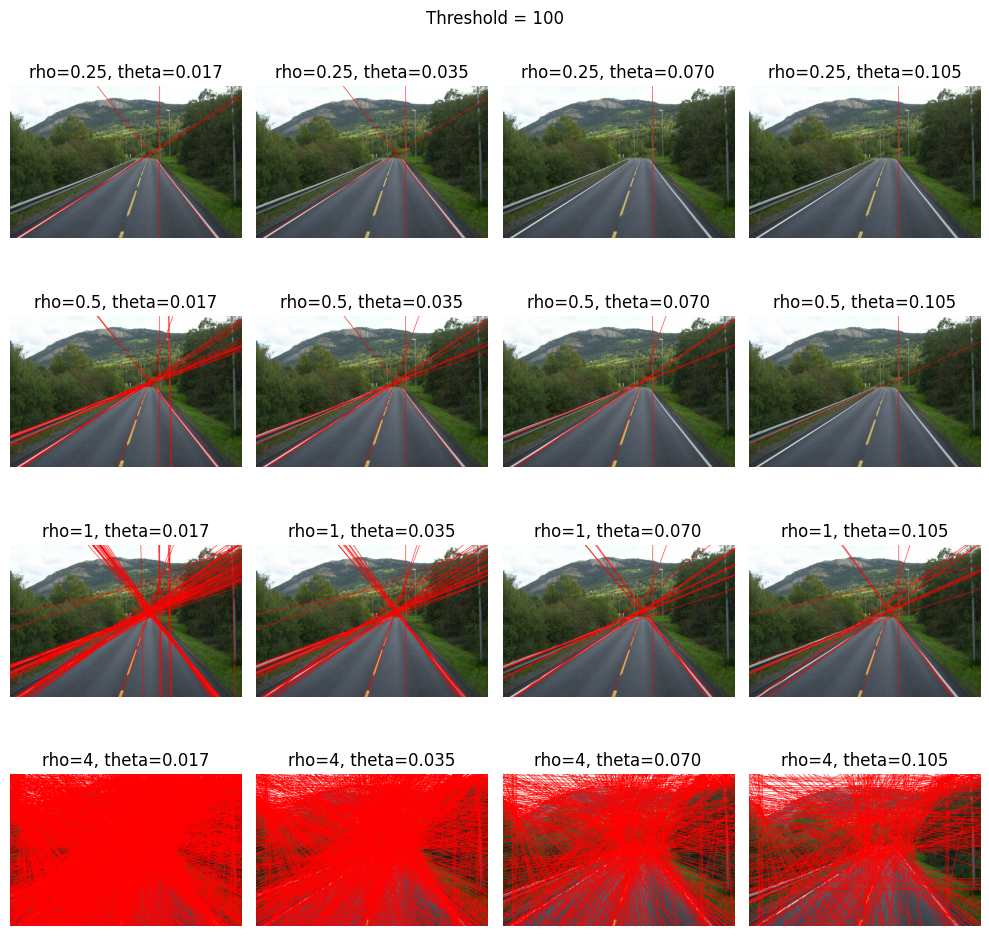

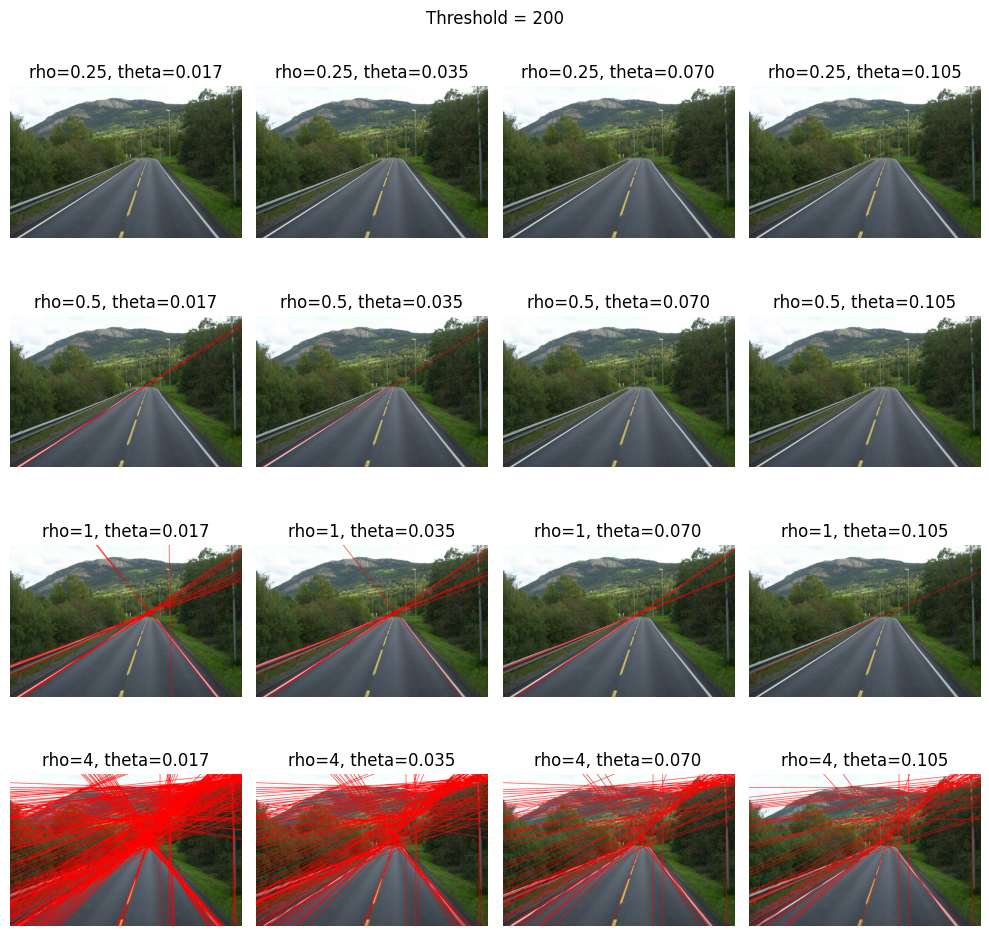

In [16]:
rho_values = [0.25, 0.5, 1, 4]
theta_values = [np.pi / 180, np.pi / 90, np.pi / 45, np.pi / 30]

threshold_values = [100, 200]

for threshold in threshold_values:
    plt.figure(figsize=(10, 10))

    for i, rho in enumerate(rho_values):
        for j, theta in enumerate(theta_values):
            plt.subplot(
                len(rho_values),
                len(theta_values),
                i * len(theta_values) + j + 1,
            )

            # detect lines using Hough transform
            lines = cv2.HoughLines(edges, rho, theta, threshold)

            # create copy of original image
            img_lines = norway.copy()

            if lines is not None:
                for line in lines:
                    x1, y1, x2, y2 = rhotheta2xy(line)
                    cv2.line(img_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

            plt.imshow(img_lines[..., ::-1])
            plt.title(f"rho={rho}, theta={theta:.3f}")
            plt.axis("off")

    plt.suptitle(f"Threshold = {threshold}")
    plt.tight_layout()

#### Zadanie 2

Dany jest obraz `pillbox`. Wykorzystaj transformację Hougha dla prostych, aby wykryć krawędzie między komórkami organizera.

Dla odmiany, w tym zadaniu nie jest istotne badanie parametrów ale wyłącznie końcowy wynik.

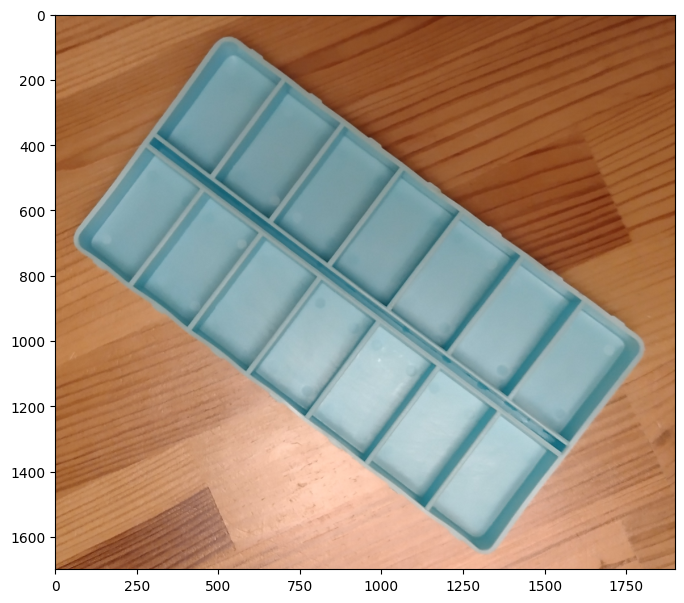

In [17]:
pillbox = cv2.imread("pillbox.png")
plt.subplots(1, 1, figsize=(8, 8))[1].imshow(pillbox[..., ::-1])

Rozwiązanie:

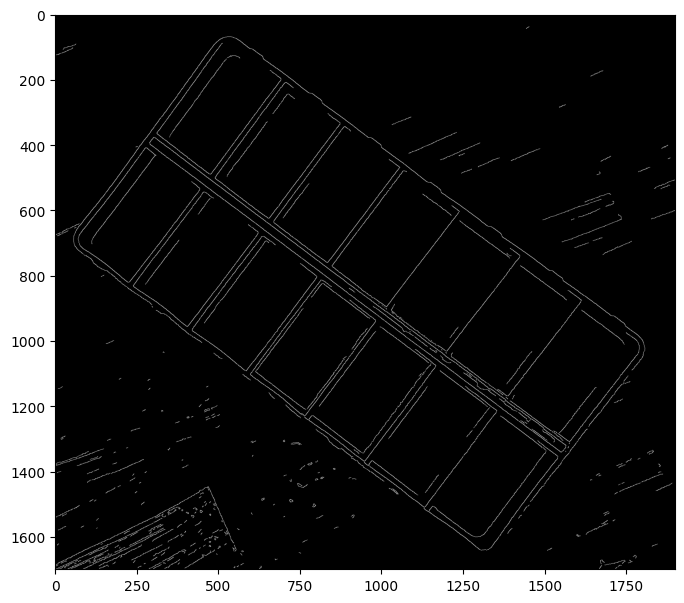

In [85]:
blur = cv2.GaussianBlur(pillbox, (5, 5), 0)
edges = cv2.Canny(blur, 50, 80)

plt.subplots(1, 1, figsize=(8, 8))[1].imshow(edges, cmap="gray")

(np.float64(-0.5), np.float64(1899.5), np.float64(1699.5), np.float64(-0.5))

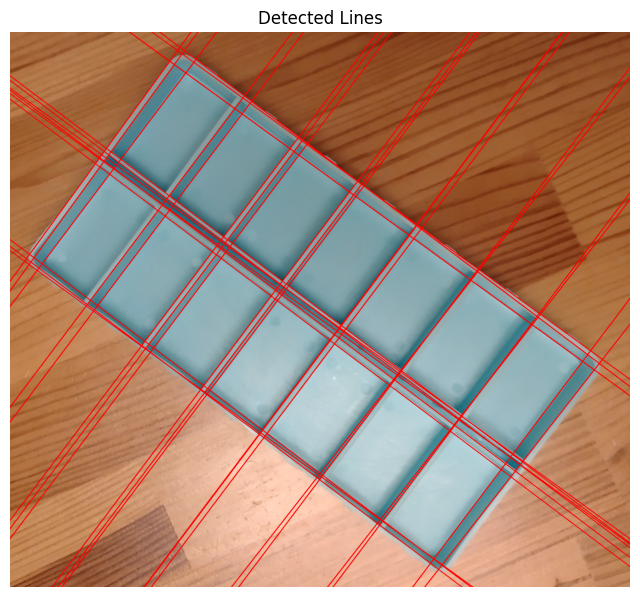

In [86]:
rho = 0.4
theta = np.pi / 180
threshold = 100

lines = cv2.HoughLines(edges, rho, theta, threshold)

img_lines = pillbox.copy()

if lines is not None:
    for line in lines:
        rho, theta = line[0]
        x1, y1, x2, y2 = rhotheta2xy(line)
        cv2.line(img_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.subplots(1, 1, figsize=(8, 8))[1].imshow(img_lines[..., ::-1])
plt.title("Detected Lines")
plt.axis("off")

(np.float64(-0.5), np.float64(1899.5), np.float64(1699.5), np.float64(-0.5))

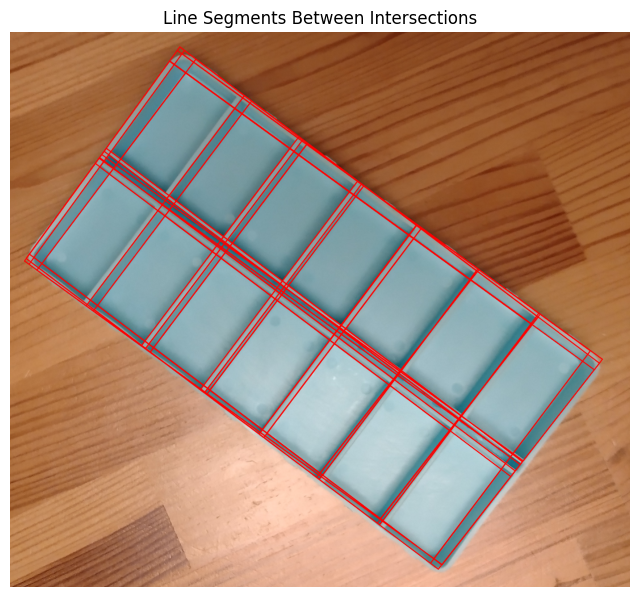

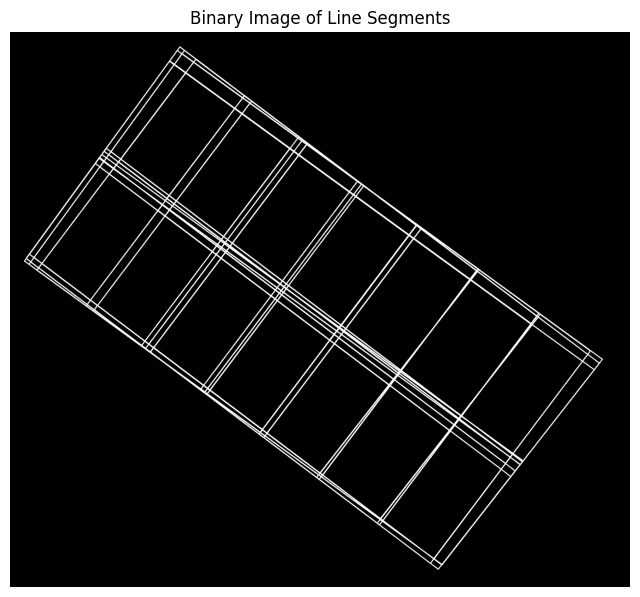

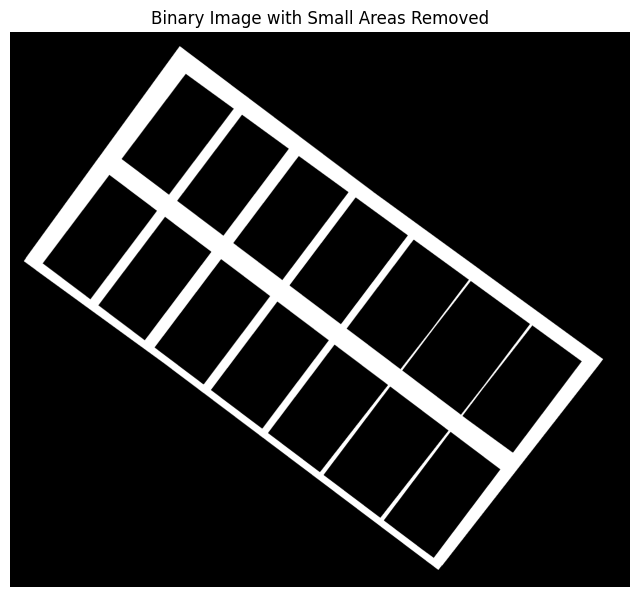

In [91]:
def find_intersection(line1, line2):
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]

    A = np.array(
        [[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]]
    )
    b = np.array([rho1, rho2])

    try:
        x, y = np.linalg.solve(A, b)
        if 0 <= x < pillbox.shape[1] and 0 <= y < pillbox.shape[0]:
            return (int(x), int(y))
    except:
        return None
    return None


# Find all intersection points for each line
intersections = {}
if lines is not None:
    for i, line1 in enumerate(lines):
        intersections[i] = []
        for j, line2 in enumerate(lines):
            if i != j:
                point = find_intersection(line1, line2)
                if point is not None:
                    intersections[i].append(point)

# Filter lines that have at least 2 intersection points and get their segments
img_filtered = pillbox.copy()
for i, line in enumerate(lines):
    if len(intersections[i]) >= 2:
        rho, theta = line[0]
        points = intersections[i]
        points.sort(key=lambda p: p[0] * np.cos(theta) + p[1] * np.sin(theta))

        for j in range(len(points) - 1):
            pt1 = points[j]
            pt2 = points[j + 1]
            cv2.line(img_filtered, pt1, pt2, (0, 0, 255), 2)

plt.subplots(1, 1, figsize=(8, 8))[1].imshow(img_filtered[..., ::-1])
plt.title("Line Segments Between Intersections")
plt.axis("off")


# Create a binary image from the line segments
binary_img = np.zeros(pillbox.shape[:2], dtype=np.uint8)

for i, line in enumerate(lines):
    if len(intersections[i]) >= 2:
        points = intersections[i]
        points.sort(
            key=lambda p: p[0] * np.cos(line[0][1]) + p[1] * np.sin(line[0][1])
        )

        for j in range(len(points) - 1):
            pt1 = points[j]
            pt2 = points[j + 1]
            cv2.line(
                binary_img,
                (int(pt1[0]), int(pt1[1])),
                (int(pt2[0]), int(pt2[1])),
                255,
                2,
            )

plt.subplots(1, 1, figsize=(8, 8))[1].imshow(binary_img, cmap="gray")
plt.title("Binary Image of Line Segments")
plt.axis("off")

# Fill in small components
binary_img = cv2.bitwise_not(binary_img)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    binary_img
)
filled_img = binary_img.copy()

min_area = 20000
for label in range(1, num_labels):
    if stats[label, cv2.CC_STAT_AREA] < min_area:
        filled_img[labels == label] = 0

filled_img = cv2.bitwise_not(filled_img)

plt.subplots(1, 1, figsize=(8, 8))[1].imshow(filled_img, cmap="gray")
plt.title("Binary Image with Small Areas Removed")
plt.axis("off")